In [28]:
import pyspark
import os
import sys
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import time

spark = (
    SparkSession.builder.appName("Sentiment Analysis with Vader") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "6") \
    .config("spark.executor.instances", "3") \
    #.config("spark.sql.shuffle.partitions", "64") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.broadcast.compress", "true") \
    .master("spark://master:7077") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://master:9000")
    .getOrCreate()
)

schema = StructType([
    StructField('marketplace', StringType(), True),
    StructField('customer_id', StringType(), True),
    StructField('review_id', StringType(), True),
    StructField('product_id', StringType(), True),
    StructField('product_parent', StringType(), True),
    StructField('product_title', StringType(), True),
    StructField('product_category', StringType(), True),
    StructField('star_rating', StringType(), True),
    StructField('helpful_votes', StringType(), True),
    StructField('total_votes', StringType(), True),
    StructField('vine', StringType(), True),
    StructField('verified_purchase', StringType(), True),
    StructField('review_headline', StringType(), True),
    StructField('review_body', StringType(), True),
    StructField('review_date', StringType(), True)
])

hdfs_path_small = 'hdfs://master:9000/user/ubuntu/datasets/amazon-us-customer-reviews-dataset/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'
hdfs_path_complete = 'hdfs://master:9000/user/ubuntu/datasets/amazon-us-customer-reviews-dataset/*.tsv'

df = spark.read.csv(hdfs_path_small, sep='\t', header=True, schema=schema)
df = df.repartition(36)

df.printSchema()
print(f"Total rows: {df.count()}")


# ----- Split 2 -----


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.storagelevel import StorageLevel
import time
from datetime import datetime

#!hdfs dfs -rm -r datasets/outputs/
!hdfs dfs -mkdir datasets/outputs/
!rm -rf ./outputs/

df_reviews = df.select('review_id', 'review_body').filter(F.col('review_body').isNotNull())

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    magnitude = compound_score
    
    return sentiment, magnitude

@F.udf(returnType=StructType([
    StructField("sentiment", StringType(), True),
    StructField("magnitude", FloatType(), True)
]))
def analyze_sentiment_udf(text):
    sentiment, magnitude = analyze_sentiment(text)
    return {"sentiment": sentiment, "magnitude": magnitude}

def remove_commas_from_review(review_text):
    if review_text:
        return review_text.replace(",", " ")
    return review_text

def save_to_csv(dataframe):
    time_start = time.time()
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_path = f"hdfs://master:9000/user/ubuntu/datasets/outputs/amazon_sentiment_results_{timestamp}"
    print(f"Csv will be saved to: {output_path}")
    
    dataframe.select("review_id", "review_body_cleaned", "sentiment", "magnitude").coalesce(1).write.option("header", "true").option("quote", "\"").mode("overwrite").csv(output_path)
    
    time_end = time.time()
    print(f"Time taken writing the csv: {time_end - time_start} seconds | Saved to: {output_path}")
    
    !mkdir ./outputs
    !hdfs dfs -get datasets/outputs/amazon_sentiment_results_{timestamp}/ ./outputs/


remove_commas_udf = F.udf(remove_commas_from_review, StringType())
time_start = time.time()

df_with_sentiment = df_reviews.withColumn("sentiment_data", analyze_sentiment_udf(F.col('review_body')))
df_with_sentiment = df_with_sentiment \
    .withColumn("sentiment", F.col("sentiment_data.sentiment").cast(StringType())) \
    .withColumn("magnitude", F.col("sentiment_data.magnitude").cast(FloatType())) \
    .drop("sentiment_data")
df_with_sentiment = df_with_sentiment.withColumn("review_body_cleaned", remove_commas_udf(F.col('review_body')))

time_end = time.time()
print(f"Time processing sentiment: {time_end - time_start} seconds")

df_with_sentiment.select('review_id', 'review_body_cleaned', 'sentiment', 'magnitude').show(50, truncate=25)
time_end_aux = time.time()
print(f"Time printing subset: {time_end_aux - time_end} seconds")

#save_to_csv(df_with_sentiment);
# ATTENTION: (For now) Do not try to save the complete dataset as a csv it will go infinitly


# ----- Split 3 -----


time_start = time.time()
df_dataset = df.join(
    df_with_sentiment.select("review_id", "sentiment", "magnitude"),
    on="review_id",
    how="left"
)
time_end = time.time()
print(f"Time merging the dataframes: {time_end - time_start} seconds")

df_dataset.show(50, truncate=25)
time_end_aux = time.time()
print(f"Time printing subset: {time_end_aux - time_end} seconds")
# ATTENTION: The print is fine, you just need to zoom out

df_dataset = df_dataset.withColumn("review_year_month", F.date_format(F.col("review_date"), "yyyy-MM"))
time_end = time.time()
print(f"Time generating graph subset: {time_end - time_end_aux} seconds")

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)

Total rows: 104975
mkdir: `datasets/outputs': File exists
Time processing sentiment: 0.07197260856628418 seconds


+--------------+-------------------------+---------+---------+
|     review_id|      review_body_cleaned|sentiment|magnitude|
+--------------+-------------------------+---------+---------+
|R2TH2D02ZNH0VW|               Works grea|  neutral|      0.0|
|R23HDWBO6CZ03L|My teenage boys love t...| positive|   0.6369|
|R1H8PBQT3F74NV|Protects the ipod quit...| positive|   0.5709|
|R2YJO6O4MOB905|I bought this as a gif...| positive|   0.9868|
| R3BW8SD7UJANK|            Doesn't work.|  neutral|      0.0|
|R19G4RQJEYSI63|                Thank you| positive|   0.3612|
|R1894U8AID4W51|Outstanding product! T...| positive|   0.9392|
|R33PYJP5KG0Q7C|Overall it was a decen...| positive|   0.9596|
|R2M0D88FOY5O28|Perfect. Excellent qua...| positive|   0.8268|
|R2MNCA3MMHKUX9|Looks great just as it...| positive|   0.9814|
|R3KPY1BNRQD4NE|Works pretty well for ...| positive|   0.9118|
|R3JZ7LOPVTFPTN|It's a good amp for th...| positive|   0.4404|
| RTN9OVC3R51J5|This was a gift and th...| positive|   

[Stage 665:=====================================================> (35 + 1) / 36]

+--------------+-----------+-----------+----------+--------------+-------------------------+------------------+-----------+-------------+-----------+----+-----------------+-------------------------+-------------------------+-----------+---------+---------+
|     review_id|marketplace|customer_id|product_id|product_parent|            product_title|  product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|          review_headline|              review_body|review_date|sentiment|magnitude|
+--------------+-----------+-----------+----------+--------------+-------------------------+------------------+-----------+-------------+-----------+----+-----------------+-------------------------+-------------------------+-----------+---------+---------+
|R107ZDCB876U8B|         US|   13288702|B008MY1F8W|     680240984|INPA K+CAN K+DCAN Car ...|Mobile_Electronics|          5|            0|          0|   N|                Y|Nice cable for coding ...|Connects to my BMW E90...| 2015

Descriptive Statistics for Star Rating and Magnitude:


+-------+------------------+------------------+
|summary|       star_rating|         magnitude|
+-------+------------------+------------------+
|  count|            104972|            104972|
|   mean| 3.763165415539382|0.4635507721964062|
| stddev|1.5234183326128385|0.5312607662280927|
|    min|                 1|           -0.9977|
|    max|                 5|            0.9999|
+-------+------------------+------------------+

Sentiment Distribution:


+---------+-----+
|sentiment|count|
+---------+-----+
| positive|79672|
|  neutral| 6761|
| negative|18539|
+---------+-----+



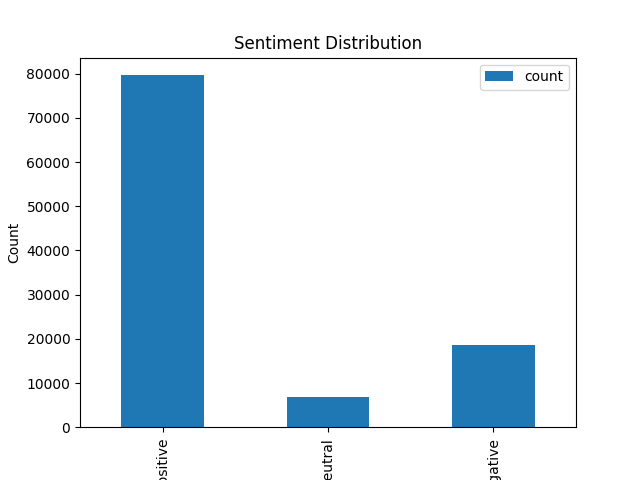

Top Positive Reviews:


PySparkValueError: product_id

In [27]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


desc_stats = df_with_sentiment.describe(['star_rating', 'magnitude'])
print("Statistics for Star Rating and Magnitude:")
desc_stats.show()

sentiment_counts = df_with_sentiment.groupBy('sentiment').count()
print("Sentiment Distribution:")
sentiment_counts.show()

sentiment_counts_pd = sentiment_counts.toPandas()
sentiment_counts_pd.plot(kind='bar', x='sentiment', y='count', title='Sentiment Distribution')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

top_positive_reviews = df_with_sentiment.filter(F.col('sentiment') == 'positive').orderBy(F.col('magnitude').desc()).limit(5)
print("Top Positive Reviews:")
for row in top_positive_reviews.collect():
    print(f"Product ID: {row['product_id']}, Title: {row['title']}, Sentiment: {row['sentiment']}, Rating: {row['star_rating']}, Magnitude: {row['magnitude']}")

top_negative_reviews = df_with_sentiment.filter(F.col('sentiment') == 'negative').orderBy(F.col('magnitude').asc()).limit(5)
print("Top Negative Reviews:")
for row in top_negative_reviews.collect():
    print(f"Product ID: {row['product_id']}, Title: {row['title']}, Sentiment: {row['sentiment']}, Rating: {row['star_rating']}, Magnitude: {row['magnitude']}")

sentiment_by_rating = df_with_sentiment.groupBy('star_rating', 'sentiment').count().orderBy('star_rating')
print("Sentiment by Star Rating:")
sentiment_by_rating.show()

sentiment_by_rating_pd = sentiment_by_rating.toPandas()
sentiment_by_rating_pd.pivot(index='star_rating', columns='sentiment', values='count').plot(kind='bar', stacked=True, title='Sentiment by Star Rating')
plt.ylabel('Count')
plt.title('Sentiment by Star Rating')
plt.show()

sentiment_over_time = df_with_sentiment.groupBy('review_year_month', 'sentiment').count().orderBy('review_year_month')
print("Sentiment Over Time:")
sentiment_over_time.show()

sentiment_over_time_pd = sentiment_over_time.toPandas()
sentiment_over_time_pd.pivot(index='review_year_month', columns='sentiment', values='count').plot(title='Sentiment Over Time')
plt.ylabel('Count')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.show()

all_reviews = ' '.join(df_with_sentiment.select('review_body').rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Bodies')
plt.show()

correlation_matrix = df_with_sentiment.select('star_rating', 'magnitude').toPandas().corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Combobox(value='', description='Select Product:', layout=Layout(margin='0 0 0 20px'), options=('85 [B002ABX29I…

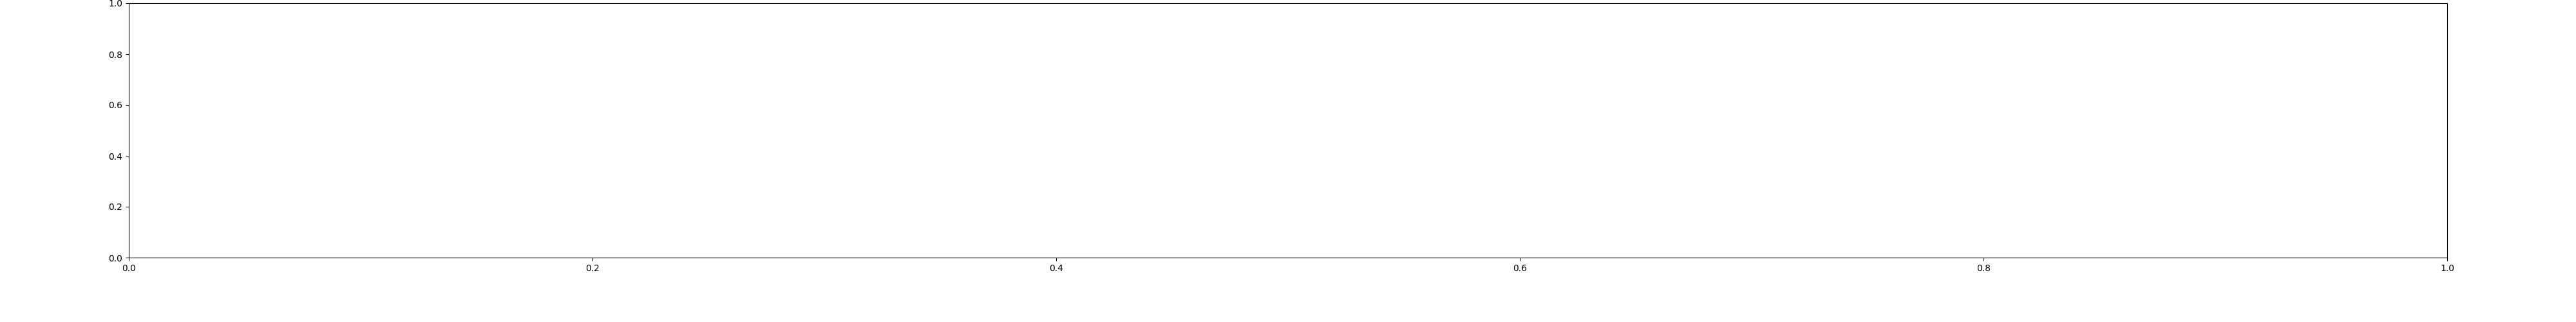

In [30]:
%matplotlib widget
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets

def preprocess_data():
    global df_dataset

    df_monthly_avg_magnitude = df_dataset.groupBy("review_year_month", "product_id", "product_title").agg(
        F.avg("magnitude").alias("avg_magnitude"),
        F.count("review_id").alias("review_count")
    )

    monthly_avg_magnitude_data = df_monthly_avg_magnitude.select(
        "review_year_month", "product_id", "product_title", "avg_magnitude", "review_count"
    ).collect()

    return [
        row for row in monthly_avg_magnitude_data 
        if row["avg_magnitude"] is not None and row["review_year_month"] is not None
    ]

monthly_avg_magnitude_data = preprocess_data()

product_options = {
    f"{row['review_count']} [{row['product_id']}] {row['product_title'][:32] + '...' if len(row['product_title']) > 32 else row['product_title']}": row['product_id']
    for row in df_dataset.select("product_id", "product_title", "review_id").groupBy("product_id", "product_title").agg(F.count("review_id").alias("review_count")).distinct().collect()
}

def plot_avg_magnitude_for_product(selected_product_id):
    ax.clear()

    filtered_data = [row for row in monthly_avg_magnitude_data if row['product_id'] == selected_product_id]
    
    avg_magnitude_x = []
    avg_magnitude_y = []
    
    for row in filtered_data:
        avg_magnitude_x.append(row["review_year_month"])
        avg_magnitude_y.append(row["avg_magnitude"])

    avg_magnitude_x = pd.to_datetime(avg_magnitude_x, errors='coerce')
    avg_magnitude_y = np.array(avg_magnitude_y)

    avg_magnitude_df = pd.DataFrame({
        'review_year_month': avg_magnitude_x,
        'avg_magnitude': avg_magnitude_y
    })
    
    avg_magnitude_df = avg_magnitude_df.dropna().sort_values(by='review_year_month')

    ax.scatter(avg_magnitude_df['review_year_month'], avg_magnitude_df['avg_magnitude'], color='darkblue', label='Average Sentiment Magnitude', zorder=3.5)

    ax.set_ylim(-1, 1.25)
    ax.set_yticks(np.arange(-1, 1.25, 0.25))

    ax.plot(avg_magnitude_df['review_year_month'], avg_magnitude_df['avg_magnitude'], color='black', linestyle='-', linewidth=2, zorder=2, alpha=0.5)
    ax.fill_between(avg_magnitude_df['review_year_month'], avg_magnitude_df['avg_magnitude'], color='gray', alpha=0.3, zorder=1)

    ax.set_xticks(avg_magnitude_df['review_year_month'])
    ax.set_xticklabels(avg_magnitude_df['review_year_month'].dt.strftime('%m/%Y'), rotation=45)
    ax.set_xlabel('Month/Year')
    ax.set_ylabel('Sentiment Magnitude')
    ax.set_title(f'Average Sentiment Magnitude for Product ID: {selected_product_id} by Month')
    ax.grid(True, linestyle='--', alpha=0.75)
    ax.legend().set_visible(False)

    plt.draw()

fig, ax = plt.subplots(figsize=(40, 5))
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, bottom=0.2)

# Create a combobox for product selection using ipywidgets with adjusted layout
product_combobox = widgets.Combobox(
    options=list(product_options.keys()),
    description='Select Product:',
    disabled=False,
    layout=widgets.Layout(margin='0 0 0 20px')  # Adjust the left margin to move it to the right
)

def on_product_selected(change):
    selected_product_id = product_options[change['new']]
    plot_avg_magnitude_for_product(selected_product_id)

product_combobox.observe(on_product_selected, names='value')

display(product_combobox)

plt.show()